<h3>Dependencies and usefull functions</h3>

In [25]:
import time
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt
%matplotlib inline

#fucntion to plot number of predictions
def plot_number_of_results(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label=f'Predictio {i}')
        plt.legend()
    plt.show()

#custom data loader also used to mannually split data to test and train
def load_data(filename, seq_len, window_normalized):
    f = open(filename, 'r').read()
    data = f.split('\n')
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    if window_normalized:
        result = window_normalizer(result)
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  
    return [x_train, y_train, x_test, y_test]

#we need to normalize a window to obtain consistent results
def window_normalizer(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def predict_point_by_point(model, data):
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_full_sequence(model, data, window_size):
    #we simply slide our window by 1 predictions at a time
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_multiple_sequences(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(len(data)//prediction_len + 1):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

<h3>Data</h3>

In [11]:
X_train, y_train, X_test, y_test = load_data('sp500_stock_data.txt', 50, True)

<h3>Building a model</h3>

In [12]:
model = Sequential()
model.add(LSTM(input_dim=1, output_dim=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(output_dim=1))
model.add(Activation('linear'))
model.compile(loss='mse', optimizer='rmsprop')

<h3>Training the model</h3>

In [15]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    nb_epoch=10,
    validation_split=0.05)

Train on 3522 samples, validate on 186 samples
Epoch 1/10
3522/3522 [==============================] - 2s 655us/step - loss: 3.7180e-04 - val_loss: 2.8427e-04
Epoch 2/10
3522/3522 [==============================] - 2s 639us/step - loss: 2.7217e-04 - val_loss: 3.3578e-04
Epoch 3/10
3522/3522 [==============================] - 3s 880us/step - loss: 2.7462e-04 - val_loss: 3.1633e-04
Epoch 4/10
3522/3522 [==============================] - 3s 857us/step - loss: 3.4433e-04 - val_loss: 2.3060e-04
Epoch 5/10
3522/3522 [==============================] - 3s 879us/step - loss: 2.7409e-04 - val_loss: 2.4291e-04
Epoch 6/10
3522/3522 [==============================] - 3s 889us/step - loss: 2.9824e-04 - val_loss: 2.8830e-04
Epoch 7/10
3522/3522 [==============================] - 3s 888us/step - loss: 2.8510e-04 - val_loss: 2.5975e-04
Epoch 8/10
3522/3522 [==============================] - 4s 1ms/step - loss: 3.1160e-04 - val_loss: 2.3739e-04
Epoch 9/10
3522/3522 [==============================] - 3s 

<h3>Plot predictions</h3>

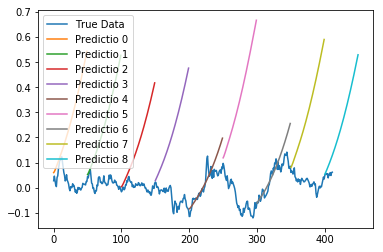

In [26]:
predictions = predict_multiple_sequences(model, X_test, 50, 50)
plot_number_of_results(predictions, y_test, 50)